In [1]:
import json
import os
import sys
from collections import defaultdict
from pathlib import Path

import mne
import numpy as np
from mne.decoding import (
    GeneralizingEstimator,
    LinearModel,
    SlidingEstimator,
    cross_val_multiscore,
    get_coef,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from vr2fem_analyses import helpers

from vr2f.staticinfo import CONFIG, PATHS

In [2]:
def avg_time(data, step=25, times=None):
    orig_shape = data.shape
    n_fill = step - (orig_shape[-1] % step)
    fill_shape = np.asarray(orig_shape)
    fill_shape[-1] = n_fill
    fill = np.ones(fill_shape) * np.nan
    data_f = np.concatenate([data, fill], axis=-1)
    data_res = np.nanmean(data_f.reshape(*orig_shape[:2], -1, step), axis=-1)

    if times is not None:
        f_times = np.r_[times, [np.nan] * n_fill]
        n_times = np.nanmean(f_times.reshape(-1, step), axis=-1)
        return data_res, n_times
    else:
        return data_res


def batch_trials(epos, batch_size, randomize=True):
    n_trials = len(epos)
    n_batches = int(n_trials / batch_size)
    n_trials = batch_size * n_batches
    if randomize:
        rnd_seq = np.arange(n_trials)
        np.random.shuffle(rnd_seq)
        rnd_seq = rnd_seq.reshape(n_batches, batch_size)
    else:
        rnd_seq = np.arange(n_trials).reshape(n_batches, batch_size)

    batches = [epos[b].average() for b in rnd_seq]
    return batches


def get_data(subID, conditions, groups=[], batch_size=1, smooth_winsize=1, picks="eeg"):
    """
    Get data for decoding.

    Parameters
    ----------
    subID : str
        Subject ID.
    conditions : list
        List of conditions to decode.
    groups : list, optional
        List of groups to decode, by default []
    batch_size : int, optional
        Batch size, by default 1
    smooth_winsize : int, optional
        Smoothing window size, by default 1
    picks : list, optional
        Channels to pick, by default "eeg"

    Returns
    -------
    X : np.ndarray
        Data.
    y : np.ndarray
        Labels.
    times_n : np.ndarray
        Times.
    info : mne.Info
        Info.
    grouping : np.ndarray
        Grouping.

    """
    paths = PATHS()
    path_in = Path(paths.DATA_03_AR, "cleaneddata")
    fname = Path(path_in, f"{subID}-postAR-epo.fif")
    epos = mne.read_epochs(fname, verbose=False).pick(picks)
    times = epos.times
    info = epos.info

    grouping = []

    # Setup data:
    if batch_size > 1:
        batches = defaultdict(list)

        for cond in conditions:
            # batches[cond] = []
            if len(groups) == 0:
                tmp = batch_trials(epos[cond], batch_size)
                batches[cond] = [b.data for b in tmp]
                grouping = np.concatenate([grouping, np.repeat(0, len(tmp))])
            else:
                for g_idx, g in enumerate(groups):
                    tmp = batch_trials(epos["/".join([cond, g])], batch_size)
                    batches[cond].extend([b.data for b in tmp])
                    grouping = np.concatenate([grouping, np.repeat(g_idx, len(tmp))])
            batches[cond] = np.asarray(batches[cond])

        X = np.concatenate([batches[c].data for c in conditions], axis=0)
        n_ = {cond: batches[cond].shape[0] for cond in conditions}

    else:
        if len(groups) > 0:
            epos = epos[groups]
        X = mne.concatenate_epochs([epos[cond] for cond in conditions])
        X = X.get_data()
        n_ = {cond: len(epos[cond]) for cond in conditions}
        if len(groups) > 0:
            for cond in conditions:
                g = np.zeros(epos[cond].events.shape[0], dtype=str)
                for i, wtf in enumerate(groups):
                    ev_ = [epos.event_id[k] for k in epos[cond].event_id.keys() if wtf in k]
                    idx = np.where(np.isin(epos[cond].events[:, 2], ev_))
                    g[idx] = i
                grouping = np.concatenate([grouping, g])
        else:
            grouping = np.repeat(0, X.shape[0])

    if smooth_winsize > 1:
        X, times_n = avg_time(X, smooth_winsize, times=times)
    else:
        times_n = times

    y = np.r_[
        np.zeros(n_[conditions[0]]),
        np.concatenate([(np.ones(n_[conditions[i]]) * i) for i in np.arange(1, len(conditions))]),
    ]

    return X, y, times_n, info, grouping


def decode(
    sub_list_str: list,
    conditions: list,
    groups=[],
    scoring: str = "roc_auc",
    n_rep_sub: int = 100,
    picks: list = "eeg",
    shuffle_labels: bool = False,
    batch_size: int = 10,
    smooth_winsize: int = 5,
    temp_gen: bool = False,
    save_single_rep_scores: bool = False,
    save_scores: bool = True,
    save_patterns: bool = False,
):
    """
    Run decoding.

    Parameters
    ----------
    sub_list_str : list
        Lsit with subject IDs.
    conditions : list
        List wit conditions to classify.
    groups : str, optional
        Grouping for CV, by default []
    scoring : str, optional
        scoring measure, by default "roc_auc"
    n_rep_sub : int, optional
        Number of repetitions, by default 100
    picks : list, optional
        Picks, by default "eeg"
    shuffle_labels : bool, optional
        Randomize the labels to generate null distribution, by default False
    batch_size : int, optional
        Number of samples to average across before classification, by default 10
    smooth_winsize : int, optional
        Number of timepoints to average across before classification, by default 5
    temp_gen : bool, optional
        Run temporal generalisation, by default False
    save_single_rep_scores : bool, optional
        Save results of all repetitions or only their average (default), by default False
    save_scores : bool, optional
        Save the scores to disc, by default True
    save_patterns : bool, optional
        Save the decoding patterns to disk, by default False

    Returns
    -------
    array :
        Scores per subject
    list :
        Coefficients per subject.
    array :
        Array of times of the batches/samples

    """
    paths = PATHS()
    config = CONFIG()
    conditions_target = [c.split("/")[-1] for c in conditions]
    if len(conditions[0].split("/")) > 1:
        if len(conditions[0].split("/")) > 2:
            raise NotImplementedError("Cannot handle more than two cond levels yet.")
        conditions_vc = [c.split("/")[0] for c in conditions]
        if len(set(conditions_vc)) > 1:
            raise ValueError("U r mixing viewing conditions. Uncool.")
        conditions_vc = conditions_vc[0]
    else:
        conditions_vc = ""

    contrast_str = "_vs_".join(conditions_target)
    scoring = scoring  # 'roc_auc' # 'accuracy'
    if len(groups) == 0:
        cv_folds = 3
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True)
    else:
        cv_folds = len(np.unique(groups))
        cv = GroupKFold(n_splits=cv_folds)

    subs_processed = list()
    sub_scores = list()
    sub_scores_per_rep = list()
    sub_coef = list()
    times_n = list()

    for subID in sub_list_str:
        print(f"### RUNING SUBJECT {subID}")
        subs_processed.append(subID)
        all_scores = list()
        all_coef = list()
        for i in np.arange(n_rep_sub):
            X, y, times_n, info, grouping = get_data(
                subID,
                conditions=conditions,
                groups=groups,
                batch_size=batch_size,
                smooth_winsize=smooth_winsize,
                picks=picks,
            )

            clf = make_pipeline(
                mne.decoding.Scaler(info),
                mne.decoding.Vectorizer(),
                LinearModel(LogisticRegression(solver="liblinear", max_iter=5000, random_state=42, verbose=False)),
            )

            # TODO: refactor: rename "se"
            if temp_gen:
                gen_str = "gen_temp"
                se = GeneralizingEstimator(clf, scoring=scoring, n_jobs=config.N_JOBS, verbose=0)
            else:
                gen_str = ""
                se = SlidingEstimator(clf, scoring=scoring, n_jobs=config.N_JOBS, verbose=0)

            if shuffle_labels:
                np.random.shuffle(y)
            # for i in np.unique(y):
            #     print(f"Size of class {i}: {np.sum(y == i)}\n")
            scores = cross_val_multiscore(se, X=X, y=y, cv=cv, groups=grouping)
            print(f"Scores: {scores.shape}")
            scores = np.mean(scores, axis=0)
            all_scores.append(scores)
            se.fit(X, y)
            coef = get_coef(se, "patterns_", inverse_transform=True)
            all_coef.append(coef)

        sub_scores = np.asarray(all_scores).mean(axis=0)
        sub_coef = np.asarray(all_coef).mean(axis=0)

        # save shizzle:
        shuf_labs = "labels_shuffled" if shuffle_labels else ""

        if picks != "eeg":
            picks_str_folder = "picks_" + "-".join([str(p) for p in picks])
        else:
            picks_str_folder = ""

        path_save = Path(
            paths.DATA_04_DECOD_SENSORSPACE,
            conditions_vc,
            contrast_str,
            gen_str,
            scoring,
            picks_str_folder,
            shuf_labs,
        )

        # save accuracies:
        if save_scores:
            fpath = Path(path_save, "scores")
            fpath.mkdir(exist_ok=True, parents=True)
            fname = Path(fpath, f"{subID}-scores_per_sub.npy")
            np.save(fname, sub_scores)
            np.save(str(fname)[:-4] + "__times" + ".npy", times_n)
            del (fpath, fname)

        # save patterns:
        if save_patterns:
            sub_patterns = sub_coef
            fpath = Path(path_save, "patterns")
            fpath.mkdir(exist_ok=True, parents=True)
            fname = Path(fpath, f"{subID}-patterns_per_sub.npy")
            np.save(fname, sub_patterns)
            np.save(str(fname)[:-4] + "__times" + ".npy", times_n)
            del (fpath, fname)

        # save info:
        if save_scores or save_patterns or save_single_rep_scores:
            info_dict = {
                "included subs": subs_processed,
                "n_rep_sub": n_rep_sub,
                "batch_size": batch_size,
                "smooth_winsize": smooth_winsize,
                "cv_folds": cv_folds,
                "scoring": scoring,
            }
            fpath = path_save
            fname = Path(fpath, f"{subID}-info.json")
            with open(fname, "w+") as outfile:
                json.dump(info_dict, outfile)

        # save data from single reps:
        if save_single_rep_scores:
            if len(sub_scores_per_rep) == 0:
                sub_scores_per_rep = np.asarray(all_scores)
            else:
                sub_scores_per_rep = np.concatenate([sub_scores_per_rep, np.asarray(all_scores)], axis=0)

            fpath = Path(path_save, "single_rep_data")
            fpath.mkdir(exist_ok=True, parents=True)
            fname = Path(
                fpath,
                f"{subID}-" f"reps{n_rep_sub}_" f"swin{smooth_winsize}_batchs{batch_size}.npy",
            )
            np.save(fname, sub_scores_per_rep)
            np.save(str(fname)[:-4] + "__times" + ".npy", times_n)
            del (fpath, fname)

    return sub_scores, sub_coef, times_n

In [8]:
paths = PATHS()
path_in = Path(paths.DATA_03_AR, "cleaneddata")

# load data
sub_list_str = [s.split("-postAR-epo")[0] for s in os.listdir(path_in)]

sub_nr = 2

if sub_nr is not None:
    sub_list_str = [sub_list_str[sub_nr]]

IndexError: list index out of range

In [107]:
for cond in ["all", "mono", "stereo"]:
    if cond == "all":
        vc = ""
    else:
        vc = cond + "/"

vc = ""
for subID in sub_list_str:
    scores, coefs, times = decode(
        [subID],
        conditions=[vc + "angry", vc + "happy"],
        groups=["mono", "stereo"],
        scoring="accuracy",
        n_rep_sub=3,
        picks="eeg",
        shuffle_labels=False,
        batch_size=3,
        smooth_winsize=20,
        temp_gen=False,
        save_single_rep_scores=False,
        save_scores=False,
        save_patterns=False,
    )

### RUNING SUBJECT VR2FEM_S23


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/33 [00:00<?,       ?it/s]

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  33 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done  10 out of  33 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  17 out of  33 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  24 out of  33 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done  31 out of  33 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/33 [00:00<?,       ?it/s]

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  33 | elapsed:    0.5s remaining:    4.8s
[Parallel(n_jobs=-2)]: Done  10 out of  33 | elapsed:    0.5s remaining:    1.2s
[Parallel(n_jobs=-2)]: Done  17 out of  33 | elapsed:    0.6s remaining:    0.6s


Scores: (2, 33)


[Parallel(n_jobs=-2)]: Done  24 out of  33 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done  31 out of  33 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/33 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/33 [00:00<?,       ?it/s]

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  33 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done  10 out of  33 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done  17 out of  33 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  24 out of  33 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done  31 out of  33 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/33 [00:00<?,       ?it/s]

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  33 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-2)]: Done  10 out of  33 | elapsed:    0.1s remaining:    0.3s


Scores: (2, 33)


[Parallel(n_jobs=-2)]: Done  17 out of  33 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  24 out of  33 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done  31 out of  33 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished


  0%|          | Fitting SlidingEstimator : 0/33 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/33 [00:00<?,       ?it/s]

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  33 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done  10 out of  33 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  17 out of  33 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done  24 out of  33 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done  31 out of  33 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/33 [00:00<?,       ?it/s]

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  33 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done  10 out of  33 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  17 out of  33 | elapsed:    0.2s remaining:    0.2s


Scores: (2, 33)


[Parallel(n_jobs=-2)]: Done  24 out of  33 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done  31 out of  33 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished


  0%|          | Fitting SlidingEstimator : 0/33 [00:00<?,       ?it/s]

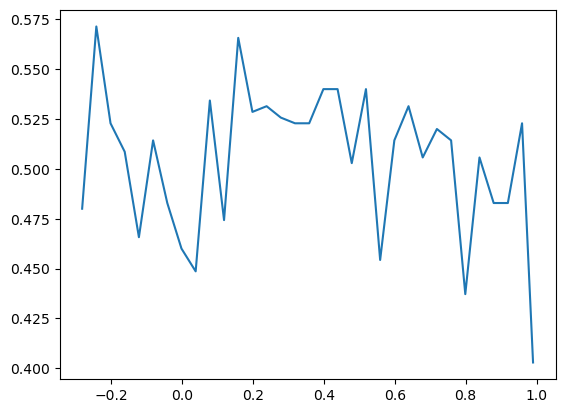

In [106]:
import matplotlib.pyplot as plt

plt.plot(times, np.array([scores]).T)

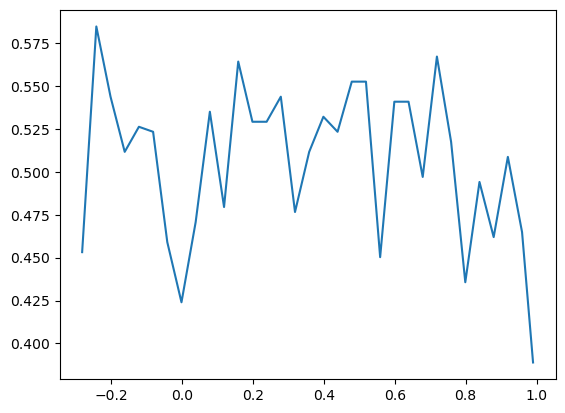

In [108]:
plt.plot(times, np.array([scores]).T)

In [ ]:
if __name__ == "__main__":
    if len(sys.argv) > 1:
        helpers.print_msg("Running Job Nr. " + sys.argv[1])
        JOB_NR = int(sys.argv[1])
    else:
        JOB_NR = None
    main(JOB_NR)